In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import os
import glob

import matplotlib as mpl
mpl.style.use('ggplot')
mpl.rcParams['figure.figsize'] = (8,6)
mpl.rcParams['font.size'] = 12

In [2]:
data = pd.read_csv("../Data/data.csv")

# TFIDF part

In [3]:
doc = data.groupby(['gender'])['line'].apply(lambda x: ' '.join(x)).reset_index()
doc.head()

,gender,line
0,female,"Fine work, as always. Well done. Thank you. ..."
1,male,What do you expect? They're savages. One lot s...


In [4]:
doc['line'] = doc['line'].str.lower()
doc.head()

,gender,line
0,female,"fine work, as always. well done. thank you. ..."
1,male,what do you expect? they're savages. one lot s...


In [5]:
doc['words'] = doc.line.str.strip().str.split('[\W_]+')
doc.head()

,gender,line,words
0,female,"fine work, as always. well done. thank you. ...","[fine, work, as, always, well, done, thank, yo..."
1,male,what do you expect? they're savages. one lot s...,"[what, do, you, expect, they, re, savages, one..."


In [6]:
rows = list()
for row in doc[['gender', 'words']].iterrows():
    r = row[1]
    for word in r.words:
        rows.append((r.gender, word))

words = pd.DataFrame(rows, columns=['gender', 'word'])
words.head()

,gender,word
0,female,fine
1,female,work
2,female,as
3,female,always
4,female,well


In [7]:
counts = words.groupby('gender')\
    .word.value_counts()\
    .to_frame()\
    .rename(columns={'word':'n_w'})
counts.head()

n_w
gender word      
female you   4055
       i     3103
       the   3050
       to    2362
       a     1587

n_w
gender word      
female you   4055
       i     3103
       the   3050
       to    2362
       a     1587
       and   1534
       s     1279
       t     1181
       it    1175
       of    1136
       me    1045
       my    1024
       he     995
       your   953
       that   806
       is     772
       for    720
       what   720
       have   707
       in     698
male   the   8879
       you   8370
       i     6923
       to    5508
       a     4426
       and   3538
       s     3337
       of    3323
       it    2743
       t     2531
       your  2370
       my    2217
       that  1983
       we    1958
       he    1956
       in    1898
       me    1871
       is    1855
       for   1834
       have  1526

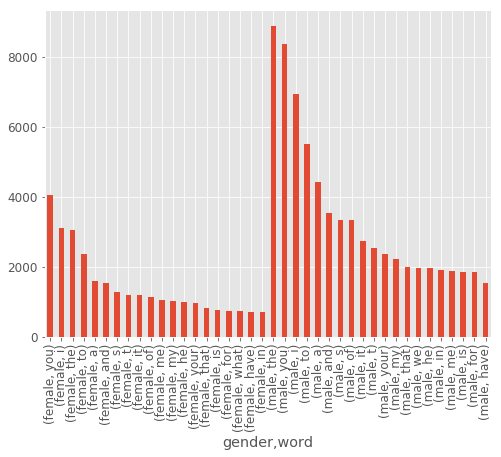

In [8]:
def plot_top_n(series, top_n=20, index_level=0):
    r = series\
    .groupby(level=index_level)\
    .nlargest(top_n)\
    .reset_index(level=index_level, drop=True)
    r.plot.bar()
    return r.to_frame()


plot_top_n(counts['n_w'])

In [9]:
word_sum = counts.groupby(level=0)\
    .sum()\
    .rename(columns={'n_w': 'n_d'})
word_sum

,n_d
gender,
female,86156
male,209906


In [10]:
tf = counts.join(word_sum)
tf['tf'] = tf.n_w/tf.n_d

tf.head()

n_w    n_d        tf
gender word                       
female you   4055  86156  0.047066
       i     3103  86156  0.036016
       the   3050  86156  0.035401
       to    2362  86156  0.027415
       a     1587  86156  0.018420

In [11]:
c_d = words.gender.nunique()
c_d

2

In [12]:
idf = words.groupby('word')\
    .gender\
    .nunique()\
    .to_frame()\
    .rename(columns={'gender':'i_d'})\
    .sort_values('i_d')
idf.head()

,i_d
word,
locking,1
northman,1
northerns,1
northeast,1
normally,1


In [13]:
idf['idf'] = np.log(c_d/idf.i_d.values)
idf.head()

,i_d,idf
word,,
locking,1,0.693147
northman,1,0.693147
northerns,1,0.693147
northeast,1,0.693147
normally,1,0.693147


In [14]:
tf_idf = tf.join(idf)
tf_idf.head()

n_w    n_d        tf  i_d  idf
gender word                                 
female you   4055  86156  0.047066    2  0.0
       i     3103  86156  0.036016    2  0.0
       the   3050  86156  0.035401    2  0.0
       to    2362  86156  0.027415    2  0.0
       a     1587  86156  0.018420    2  0.0

In [15]:
tf_idf['tf_idf'] = tf_idf.tf * tf_idf.idf
tf_idf.head()

n_w    n_d        tf  i_d  idf  tf_idf
gender word                                         
female you   4055  86156  0.047066    2  0.0     0.0
       i     3103  86156  0.036016    2  0.0     0.0
       the   3050  86156  0.035401    2  0.0     0.0
       to    2362  86156  0.027415    2  0.0     0.0
       a     1587  86156  0.018420    2  0.0     0.0

tf_idf
gender word                   
female clams          0.000072
       dove           0.000056
       drogon         0.000056
       momma          0.000056
       dracarys       0.000048
       lemon          0.000048
       nymeria        0.000048
       polliver       0.000048
       cockels        0.000040
       obara          0.000040
       adore          0.000032
       agony          0.000032
       extraordinary  0.000032
       heal           0.000032
       healed         0.000032
       leftovers      0.000032
       luthor         0.000032
       reyne          0.000032
       zuriff         0.000032
       alanna         0.000024
male   mhysa          0.000106
       huh            0.000083
       loose          0.000076
       during         0.000073
       alliser        0.000069
       thorne         0.000069
       ranger         0.000063
       rangers        0.000059
       uh             0.000056
       size           0.000050
       willem         0.000050
       witness        0.000050
       ideas          0.000046
       reading        0.000046
       steward        0.000046
       admire         0.000043
       archers        0.000043
       archmaester    0.000043
       horn           0.000043
       khuu           0.000043

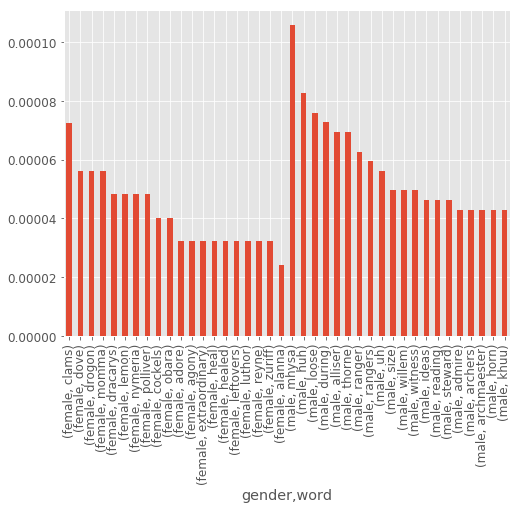

In [16]:
plot_top_n(tf_idf['tf_idf'])

Words like clams, dove, lemon, adore, heal[ed] are more distinctive of female characters. Words like loose, ranger[s], witness, ideas, reading are more distinctive of male characters. Stemming should be looked into.

# Distinctive Words

In [17]:
from math import log
import nltk
from nltk import FreqDist
from pandasql import sqldf

pysqldf = lambda q: sqldf(q, globals())

In [18]:
with open("../files/stopwords.txt", "r") as f:
    STOP_WORDS = set(f.read().strip().split("\n"))

In [19]:
df = data.groupby(['gender'])['line'].apply(lambda x: ' '.join(x)).reset_index()

female = df[df.gender == 'female']
male = df[df.gender == 'male']

female['line'] = female['line'].str.lower()
male['line'] = male['line'].str.lower()

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [20]:
female_freq_dist = FreqDist(nltk.word_tokenize(" ".join(female.line.values)))
male_freq_dist = FreqDist(nltk.word_tokenize(" ".join(male.line.values)))

In [21]:
male_freq_dist = {k:v for k,v in male_freq_dist.items() if v > 5}
n_male = sum(male_freq_dist.values())

female_freq_dist = {k:v for k,v in female_freq_dist.items() if v > 5}
n_female = sum(female_freq_dist.values())

In [22]:
femaleness = {}

for w in female_freq_dist.keys() & male_freq_dist.keys():
    if len(w) > 2:
        femaleness[w] = log((female_freq_dist[w] / n_female) / (male_freq_dist[w] / n_male))

In [23]:
df = pd.DataFrame.from_dict(femaleness, orient='index').reset_index()
df = df.rename(index=str, columns={"index": "word", 0: "score"})

In [24]:
df.head()

,word,score
0,doesn,-0.523182
1,like,0.117549
2,gon,-0.328758
3,gods,0.175242
4,knows,-0.741049


## Most Distinctive Words to Female Characters

In [25]:
pysqldf("SELECT word, score FROM df ORDER BY 2 DESC LIMIT 20")

,word,score
0,handsome,1.743858
1,liar,1.645418
2,husband,1.565875
3,shh,1.504966
4,betray,1.504966
5,arya,1.501127
6,sky,1.428005
7,felt,1.428005
8,interested,1.369164
9,robin,1.369164


## Least Distinctive Words to Female Characters

In [26]:
pysqldf("SELECT word, score FROM df ORDER BY 2 ASC LIMIT 20")

,word,score
0,commander,-1.656281
1,fucking,-1.581521
2,hodor,-1.214448
3,order,-1.182882
4,steel,-1.125895
5,realm,-1.114253
6,shit,-1.105104
7,wall,-1.072111
8,fine,-1.056902
9,walls,-1.048934


# Creator Distinctive Words

In [27]:
f_writer = data[(data.season_episode == 's02e04') | (data.season_episode == 's02e06') | (data.season_episode == 's03e02')]
m_writer = data[(data.season_episode == 's05e04') | (data.season_episode == 's06e02') | (data.season_episode == 's07e05')]

f_writer = f_writer.groupby(['gender'])['line'].apply(lambda x: ' '.join(x)).reset_index()
m_writer = m_writer.groupby(['gender'])['line'].apply(lambda x: ' '.join(x)).reset_index()

female['line'] = f_writer['line'].str.lower()
male['line'] = m_writer['line'].str.lower()

In [28]:
female_freq_dist = FreqDist(nltk.word_tokenize(" ".join(female.line.values)))
male_freq_dist = FreqDist(nltk.word_tokenize(" ".join(male.line.values)))

In [29]:
male_freq_dist = {k:v for k,v in male_freq_dist.items() if v > 5}
n_male = sum(male_freq_dist.values())

female_freq_dist = {k:v for k,v in female_freq_dist.items() if v > 5}
n_female = sum(female_freq_dist.values())

In [30]:
femaleness = {}

for w in female_freq_dist.keys() & male_freq_dist.keys():
    if len(w) > 2:
        femaleness[w] = log( (female_freq_dist[w] / n_female) / (male_freq_dist[w] / n_male))

In [31]:
df = pd.DataFrame.from_dict(femaleness, orient='index').reset_index()
df = df.rename(index=str, columns={"index": "word", 0: "score"})

## Most Distinctive Words to Female Writer

In [32]:
pysqldf("SELECT word, score FROM df ORDER BY 2 DESC LIMIT 20")

,word,score
0,any,1.320544
1,very,1.261703
2,lord,0.947869
3,want,0.909802
4,before,0.905028
5,lady,0.883826
6,make,0.809718
7,those,0.809718
8,name,0.809718
9,look,0.809718


## Least Distinctive Words to Female Writer

In [33]:
pysqldf("SELECT word, score FROM df ORDER BY 2 ASC LIMIT 20")

,word,score
0,like,-0.544827
1,all,-0.517153
2,she,-0.481266
3,why,-0.463247
4,get,-0.394255
5,the,-0.380222
6,'ll,-0.375905
7,one,-0.368937
8,but,-0.201883
9,way,-0.188811
